
# Optimal power flow model in Julia

In [1]:
import Pkg

# activate parent environment
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()
Pkg.status()

using CSV
using DataFrames
using Dates
using TimeZones
using CairoMakie
using JuMP
import JSON
import MathOptInterface as MOI

using Revise
using OptHP

  Activating project at `c:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Manifest.toml`


Status `C:\Users\lange\OneDrive\Projects\2024\EEM25\Congestion-Management-based-on-Thermal-Comfort\Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.13.1
  [a93c6f00] DataFrames v1.7.0
  [682c06a0] JSON v0.21.4
  [4076af6c] JuMP v1.23.6
  [b8f27783] MathOptInterface v1.35.1
  [2d871509] OptHP v1.0.0-DEV `OptHP`
  [295af30f] Revise v3.7.1
  [f269a46b] TimeZones v1.20.0
  [ade2ca70] Dates


## Load data

In [2]:
network = CSV.read("data/network.csv", DataFrame)
first(network, 5)

Row,StartNode,EndNode,Length,cable,Inom,R,X
,Int64,Int64,Float64,String7,Float64,Float64,Float64
1,47,15,22.21,50Al,0.12528,0.0142366,0.00188785
2,49,40,15.57,95Al,0.18386,0.0049824,0.00127674
3,26,41,18.26,95Al,0.18386,0.0058432,0.00149732
4,11,12,6.71,95Al,0.18386,0.0021472,0.00055022
5,12,27,6.52,95Al,0.18386,0.0020864,0.00053464


In [3]:
connections = CSV.read("data/user_connect.csv", DataFrame; delim=";")

# convert PV (str) to Float64
connections.PV = parse.(Float64, replace.(connections.PV, "," => "."))

first(connections, 5)

Row,Column1,Name,Node.ID,Node.Unom,Length,Type short,Connection value,load,PV,HP,Node
,Int64,Int64,Int64,Int64,String7,String15,String7,Int64,Float64,Int64,Int64
1,1,871694840006284337,46559968,230,"21,75",XLPE 4x6Cu,3x25 A,7000,4.0,1,50
2,2,871694840006288793,46563894,230,"2,22",XLPE 4x6Cu,3x25 A,7000,6.0,0,51
3,3,871694840006284108,11195660,230,"10,4",PVC 4x16Al,1x35 A,2000,2.2,0,52
4,4,871694840006284115,11195660,230,"10,4",PVC 4x16Al,1x35 A,500,2.2,0,53
5,5,871694840006284092,2573422,230,"7,33",PVC 4x16Al,1x35 A,2000,2.2,0,54


In [4]:
loads_real = CSV.read("data/UserPower.csv", DataFrame)
loads_real.time = DateTime.(loads_real.time, "m/d/yyyy H:M p")

loads_reactive = CSV.read("data/UserReactivePower.csv", DataFrame)
loads_reactive.time = DateTime.(loads_reactive.time, "m/d/yyyy H:M p")

# Filter for rows where the date is February 1, 2024
date = Date(2024, 2, 1)
loads_real = loads_real[Date.(loads_real.time) .== date, 3:end] .* 10
loads_reactive = loads_reactive[Date.(loads_reactive.time) .== date, 3:end] .* 10
first(loads_real, 5)

Row,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.280492,0.327633,0.0789328,0.0216432,0.0870451,0.066902,0.190303,0.208217,0.316786,0.0885476,0.0227458,0.100109,0.0389288,0.0391422,0.217207,0.0663473,0.137514,0.38904,0.160743,0.134882,0.108427,0.44233,0.0783649,0.0964245,0.327462,0.462532,0.159094,0.085621,0.220982,0.0783409,0.0924792,0.118713,0.25677,0.19321,0.138463,0.255821,0.0
2,0.194261,0.201885,0.0556897,0.0150743,0.0557323,0.0408914,0.129535,0.161562,0.188356,0.0547041,0.0150153,0.0703371,0.0301253,0.0301947,0.136849,0.0469629,0.110687,0.308354,0.108854,0.103217,0.0754248,0.315925,0.0559041,0.0759827,0.213481,0.281427,0.101261,0.0647718,0.135207,0.0579418,0.0582512,0.0873516,0.18251,0.13007,0.0943072,0.178395,0.0
3,0.222562,0.222175,0.0583958,0.0149652,0.0583324,0.040186,0.131774,0.146778,0.221186,0.063148,0.0160216,0.0741227,0.0291713,0.0310672,0.151385,0.0471799,0.109297,0.284821,0.112424,0.0954143,0.0796256,0.309558,0.0559076,0.0797005,0.227603,0.303833,0.111911,0.058502,0.160791,0.0646978,0.0603232,0.0961901,0.193459,0.125066,0.0844744,0.178119,0.0
4,0.236077,0.214192,0.0656782,0.0158927,0.0727005,0.0480448,0.148979,0.172582,0.21615,0.0741563,0.0154189,0.0765452,0.0309739,0.0323702,0.160809,0.0554229,0.12016,0.365018,0.146685,0.129499,0.0916666,0.329395,0.0737826,0.0877966,0.230161,0.328368,0.108052,0.0674518,0.164615,0.0639536,0.0619007,0.105051,0.187594,0.137561,0.10025,0.20322,0.0
5,0.258527,0.26771,0.0830569,0.0182058,0.0881239,0.0562766,0.188999,0.181352,0.267452,0.0775641,0.0204764,0.0959481,0.0368743,0.0390459,0.200733,0.0636839,0.138178,0.417959,0.160488,0.146582,0.0963903,0.412269,0.0812958,0.0960557,0.266,0.380806,0.141561,0.0851961,0.213948,0.0755007,0.0783836,0.122754,0.233571,0.186267,0.109073,0.241358,0.0


## Load state-space matrices

In [5]:
id = "H14"

A_d = Matrix(CSV.read("data/$(id)/$(id)_15min_A_exact.csv", DataFrame))
B_d = Matrix(CSV.read("data/$(id)/$(id)_15min_B_exact.csv", DataFrame))

H14_meta = Dict(
    "A" => A_d,
    "B" => B_d
)

meta = Dict(
    "H14" => H14_meta
)

Dict{String, Dict{String, Matrix{Float64}}} with 1 entry:
  "H14" => Dict("B"=>[0.00663784 0.00224598 0.166439; 9.37536e-5 2.65051e-6 0.0…

## Read weather data

In [6]:
weather_df = CSV.read("data/weather/weather.csv", DataFrame)
select!(weather_df, Not([:interpolated]))
rename!(weather_df, Dict("P_solar" => "Φ_s", "T_ambient" => "T_a"))

dt_format = "yyyy-mm-ddTHH:MM:SS.sss+zzzz"
weather_df.timestamp = ZonedDateTime.(String.(weather_df.timestamp), dt_format)
weather_df = interpolate_data(weather_df, 15)

# select a particular day
date = Date(2024, 4, 1)
weather_df = weather_df[Date.(weather_df.timestamp) .== date, :]

# add electricity price [€/kWh]
weather_df.λ_e .= 0.21

# convert Φ_s from W to kW
weather_df.Φ_s .= weather_df.Φ_s ./ 1000

println("Weather data shape: ", size(weather_df))
first(weather_df, 5)

Interpolating columns: [:Φ_s, :T_a]
Weather data shape: (96, 4)


Row,timestamp,Φ_s,T_a,λ_e
,ZonedDat…,Float64,Float64,Float64
1,2024-04-01T00:00:00+00:00,0.0,9.6,0.21
2,2024-04-01T00:15:00+00:00,0.0,9.45,0.21
3,2024-04-01T00:30:00+00:00,0.0,9.6,0.21
4,2024-04-01T00:45:00+00:00,0.0,9.3,0.21
5,2024-04-01T01:00:00+00:00,0.0,9.1,0.21


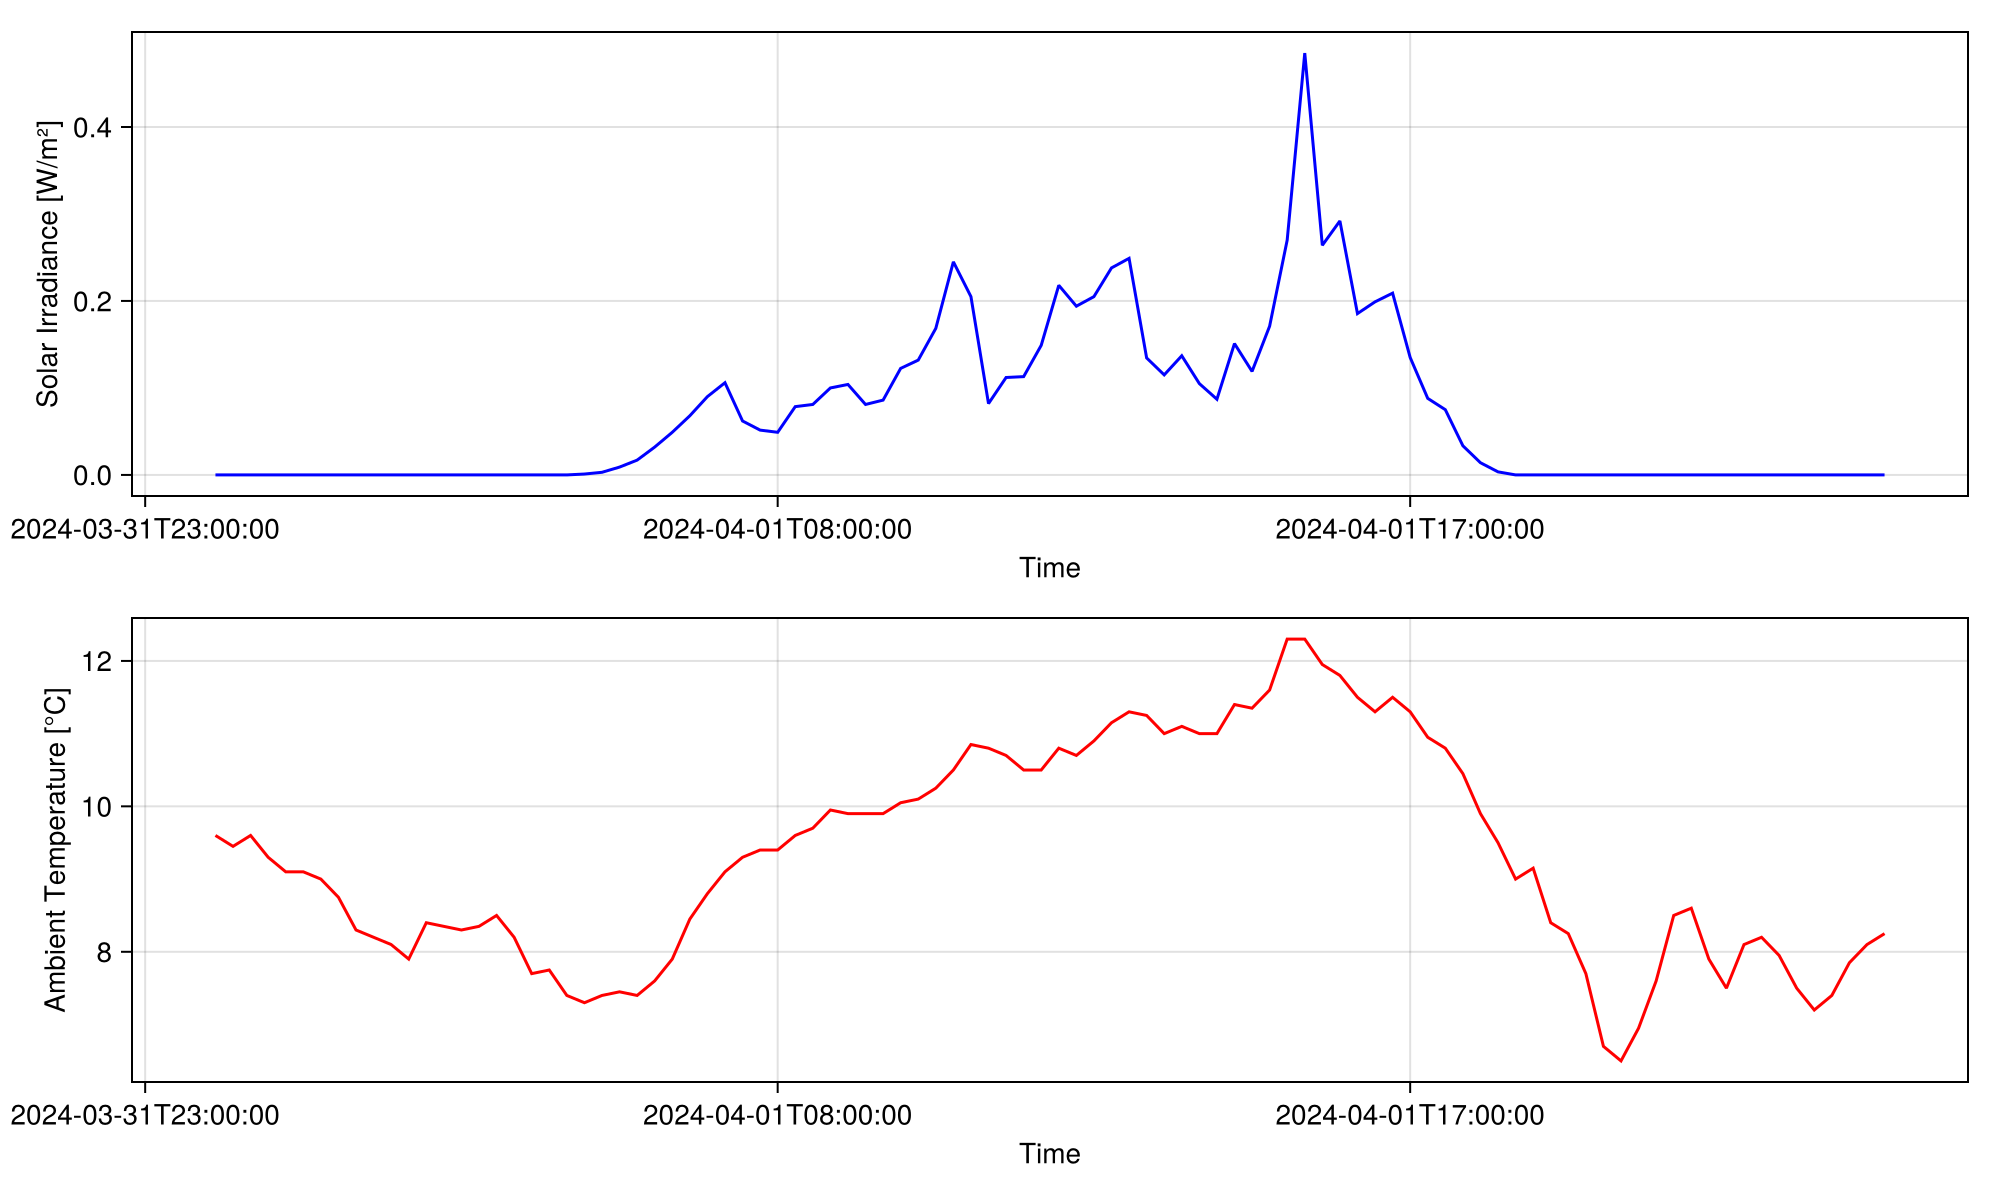

In [7]:
# plot the weather data
fig = Figure(; size = (1000, 600))

ax1 = Axis(fig[1, 1], xlabel="Time", ylabel="Solar Irradiance [W/m²]")
ax2 = Axis(fig[2, 1], xlabel="Time", ylabel="Ambient Temperature [°C]")

lines!(ax1, DateTime.(weather_df.timestamp), weather_df.Φ_s, color=:blue)
lines!(ax2, DateTime.(weather_df.timestamp), weather_df.T_a, color=:red)

fig

## Plot user power in kW

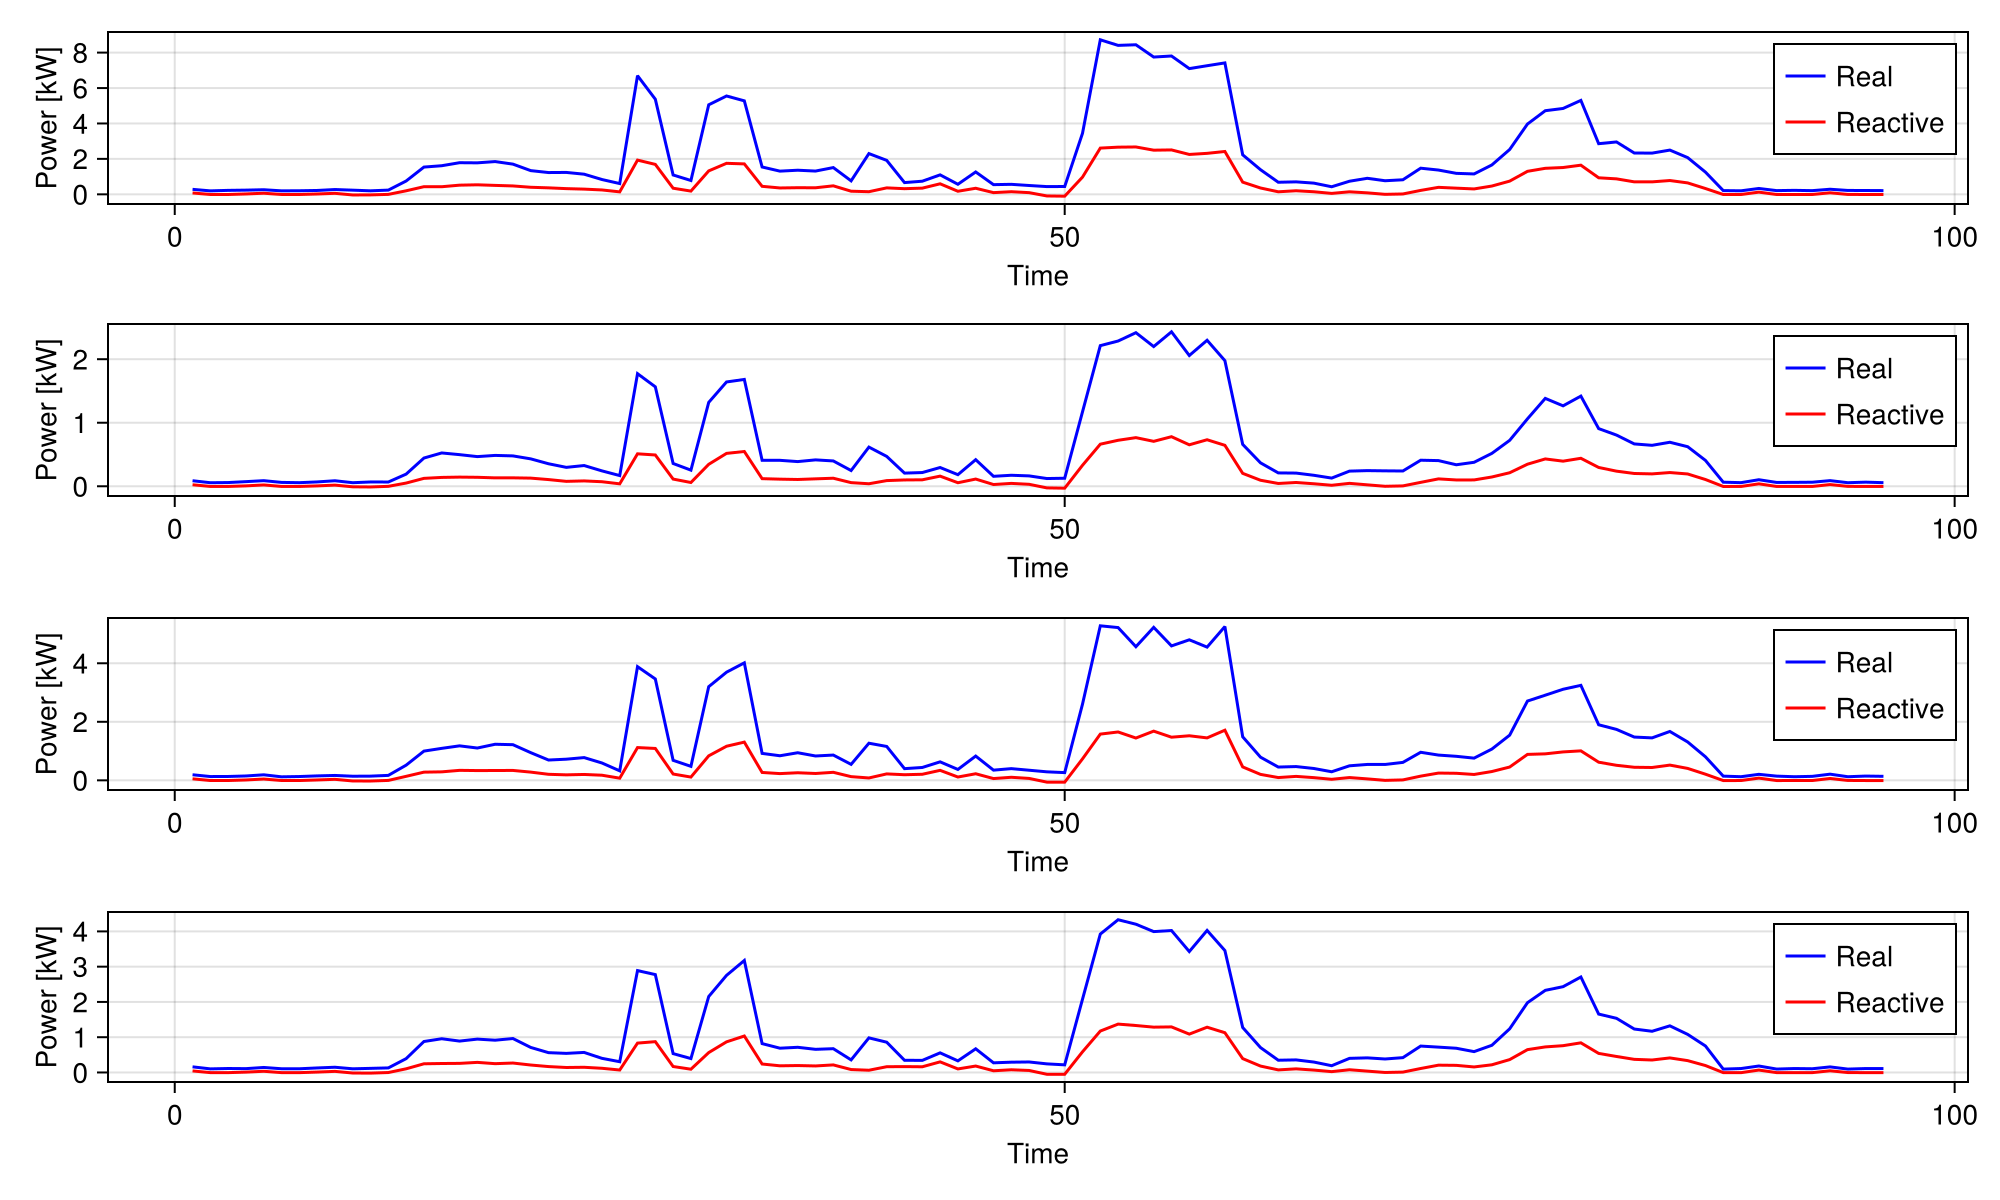

In [8]:
# plot user power data
fig = Figure(; size = (1000, 600))

for (i,user) in enumerate([50,54,56,76])

    ax = Axis(fig[i, 1], xlabel="Time", ylabel="Power [kW]")
    lines!(ax, loads_real[:, "$user"], label="Real", color=:blue)
    lines!(ax, loads_reactive[:, "$user"], label="Reactive", color=:red)
    axislegend(ax)
end

fig

## Grid model with test data

In [9]:
# test network with 4 buses 
#       0   (slack)
#       |
#       1   (junction)
#      / \
#     2   3 (loads)

network_test = DataFrame(
    StartNode = [0, 1, 1],
    EndNode = [1, 2, 3],
    Length = [1.0, 1.0, 1.0],
    Inom = [0.1, 0.1, 0.1],
    R = [0.01, 0.01, 0.01],
    X = [0.01, 0.01, 0.01]
)

# grid connections
connections_test = DataFrame(
    HP = [0, 0],
    Node = [2, 3]
)

# loads real 
loads_real_test = DataFrame(
    Symbol("2") => [4.0, 4.0, 4.0, 4.0, 4.0],
    Symbol("3") => [6.0, 6.0, 6.0, 6.0, 6.0]
)
loads_reactive_test = DataFrame(
    Symbol("2") => zeros(5),
    Symbol("3") => zeros(5)
);

In [10]:
# compute_conflict!(model)

In [11]:
# primal_feasibility_report(model)

In [36]:
# model[:ConicOPF]
# model[:RealPowerBalance]
# model[:Transmission]
# model[:RealBaseLoad]
model[:P_line]

2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, [(1, 2), (0, 1), (1, 3)]
    Dimension 2, 1:1
And data, a 3×1 Matrix{VariableRef}:
 PLineFlow[(1, 2),1]
 PLineFlow[(0, 1),1]
 PLineFlow[(1, 3),1]

In [37]:
model[:Q_line]

2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, [(1, 2), (0, 1), (1, 3)]
    Dimension 2, 1:1
And data, a 3×1 Matrix{VariableRef}:
 QLineFlow[(1, 2),1]
 QLineFlow[(0, 1),1]
 QLineFlow[(1, 3),1]

In [34]:
model = GEC(network=network_test, 
            connections=connections_test, 
            loads_real=loads_real_test, 
            loads_reactive=loads_reactive_test,   
            weather=weather_df,    
            meta = meta,
            silent=false,
            T=1:1
)

Set parameter Username
Set parameter LicenseID to value 2599292
Academic license - for non-commercial use only - expires 2025-12-13
B: Set([0, 2, 3, 1])
H: Set([2, 3])
H_HP: Set{Union{}}()
T: 1:1
L: Set([(1, 2), (0, 1), (1, 3)])
grid: Grid with 4 buses and 3 lines over 1 time steps

grid.buses: 
(SlackBus: 0 with adjacent: [1]
, UserBus: 2 adjacent: [1]
, UserBus: 3 adjacent: [1]
, JunctionBus: 1 with adjacent: [0,2,3]
)
grid.lines: 
(0 -> 1 [X: 0.01, R: 0.01, Inom: 100.0]
, 1 -> 2 [X: 0.01, R: 0.01, Inom: 100.0]
, 1 -> 3 [X: 0.01, R: 0.01, Inom: 100.0]
)


A JuMP Model
├ solver: Gurobi
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 21
├ num_constraints: 29
│ ├ AffExpr in MOI.EqualTo{Float64}: 16
│ ├ AffExpr in MOI.LessThan{Float64}: 1
│ ├ QuadExpr in MOI.GreaterThan{Float64}: 3
│ ├ QuadExpr in MOI.LessThan{Float64}: 1
│ ├ VariableRef in MOI.GreaterThan{Float64}: 4
│ └ VariableRef in MOI.LessThan{Float64}: 4
└ Names registered in the model
  └ :ConicOPF, :I_line, :J_loss, :P, :P_line, :Q, :Q_line, :ReactiveBaseLoad, :ReactivePowerBalance, :RealBaseLoad, :RealPowerBalance, :TrafoLimit, :TrafoPowerLimitForCongestion, :Transmission, :VoltageDrop, :v

## Construct GEC

In [ ]:
# model = GEC(network=network, 
#             connections=connections, 
#             loads_real=loads_real, 
#             loads_reactive=loads_reactive,   
#             weather=weather_df,    
#             meta = meta,
#             silent=false,
#             T=1:2
# )

## Test some outputs

In [ ]:
# plot using Makie
fig = Figure(; size = (1000, 600))
ax = Axis(fig[1, 1], xlabel = "Time [hours]", 
    ylabel = "Power [kW]", 
    title = "Power flow",
    xticks = (1:4:97, string.(0:1:24))
)

# index of slack bus (transformer)
SB = argmin(value.(model[:P]).axes[2])
P_trafo = Matrix(value.(model[:P]; result=1))[:, SB] .* -1E3


# lines!(ax, sol[:P], color = :blue, label = "Transformer", linestyle = :so
scatterlines!(ax, P_trafo, color = :blue, label = "P trafo", linewidth = 2)
axislegend(ax, position = :lb)

# display
fig
